# 데이터 불러오기 및 패키지 로딩

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 5.7 MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc
from scipy import interp

import shap

### 코랩용

In [ ]:
from google.colab import files 
myfile = files.upload()

import io 
import pandas as pd

Saving clinical.csv to clinical.csv
Saving HRVCli.csv to HRVCli.csv
Saving HRV.csv to HRV.csv
Saving EEGHRVCli.csv to EEGHRVCli.csv
Saving EEGHRV.csv to EEGHRV.csv
Saving EEGCli.csv to EEGCli.csv
Saving EEG.csv to EEG.csv
Saving selected_features.xlsx to selected_features.xlsx


In [ ]:
HRV = pd.read_csv(io.BytesIO(myfile['HRV.csv']))
EEG = pd.read_csv(io.BytesIO(myfile['EEG.csv']))
clinical = pd.read_csv(io.BytesIO(myfile['clinical.csv']))

EEGHRV = pd.read_csv(io.BytesIO(myfile['EEGHRV.csv']))
HRVCli = pd.read_csv(io.BytesIO(myfile['HRVCli.csv']))
EEGCli = pd.read_csv(io.BytesIO(myfile['EEGCli.csv']))

EEGHRVCli = pd.read_csv(io.BytesIO(myfile['EEGHRVCli.csv']))

In [ ]:
cl1_features = pd.read_excel(io.BytesIO(myfile['selected_features.xlsx']),sheet_name = 0)
cl2_features = pd.read_excel(io.BytesIO(myfile['selected_features.xlsx']),sheet_name = 1)
cl3_features = pd.read_excel(io.BytesIO(myfile['selected_features.xlsx']),sheet_name = 2)
cl4_features = pd.read_excel(io.BytesIO(myfile['selected_features.xlsx']),sheet_name = 3)

### jupyter notebook

HRV = pd.read_csv('HRV.csv', encoding='CP949')
EEG = pd.read_csv('EEG.csv', encoding='CP949')
clinical = pd.read_csv('clinical.csv', encoding='CP949')

EEGHRV = pd.read_csv('EEGHRV.csv', encoding='CP949')
HRVCli = pd.read_csv('HRVCli.csv', encoding='CP949')
EEGCli = pd.read_csv('EEGCli.csv', encoding='CP949')

EEGHRVCli = pd.read_csv('EEGHRVCli.csv', encoding='CP949')

In [ ]:
HRV.columns = [re.sub("\(|\)|\-|\ ",".",HRV.columns.values[i]) for i in range(0,len(HRV.columns.values))]
EEG.columns = [re.sub("\(|\)|\-|\ ",".",EEG.columns.values[i]) for i in range(0,len(EEG.columns.values))]
clinical.columns = [re.sub("\(|\)|\-|\ ",".",clinical.columns.values[i]) for i in range(0,len(clinical.columns.values))]
EEGHRV.columns = [re.sub("\(|\)|\-|\ ",".",EEGHRV.columns.values[i]) for i in range(0,len(EEGHRV.columns.values))]
HRVCli.columns = [re.sub("\(|\)|\-|\ ",".",HRVCli.columns.values[i]) for i in range(0,len(HRVCli.columns.values))]
EEGCli.columns = [re.sub("\(|\)|\-|\ ",".",EEGCli.columns.values[i]) for i in range(0,len(EEGCli.columns.values))]
EEGHRVCli.columns = [re.sub("\(|\)|\-|\ ",".",EEGHRVCli.columns.values[i]) for i in range(0,len(EEGHRVCli.columns.values))]

In [ ]:
clinical.rename(columns = {'3.education' : 'X3.education', '5.marriage' : 'X5.marriage'}, inplace = True)
HRVCli.rename(columns = {'3.education' : 'X3.education', '5.marriage' : 'X5.marriage'}, inplace = True)
EEGCli.rename(columns = {'3.education' : 'X3.education', '5.marriage' : 'X5.marriage'}, inplace = True)
EEGHRVCli.rename(columns = {'3.education' : 'X3.education', '5.marriage' : 'X5.marriage'}, inplace = True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 함수정의


## 전처리 함수
* input설명
* data
* cls1,2,3 / 4 는 3-class

In [ ]:
def pre_processing(data,cls) : # cls1,2,3 ,4는 3클

    if (cls == 1):
        data = data.drop(data[(data['group']=='IGD')].index, axis=0)
        data['group'] = data.group.replace({'HC':0, 'AUD':1}).astype('category')

    if (cls == 2):
        data = data.drop(data[(data['group']=='AUD')].index, axis=0)
        data['group'] = data.group.replace({'HC':0, 'IGD':1}).astype('category')

    if (cls == 3):
        data['group'] = data.group.replace({'HC':0, 'AUD':1, 'IGD':1}).astype('category')

    if (cls == 4):
        data['group'] = data.group.replace({'HC':0, 'AUD':1, 'IGD':2}).astype('category')

    # scaling

    rmv_lst = ['group','sex','X5.marriage']
    apend_lst = [s for s in rmv_lst if s in data.columns]
    scale_lst = [s for s in data.columns if s not in rmv_lst]  

    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[scale_lst]),
                               index=data.index, columns=data[scale_lst].columns)
    scaled_data[apend_lst] = data[apend_lst]

    return scaled_data

## 그림 함수

In [ ]:
# feature imp 그리는 함수
def feature_importances(model_name, importance, names):

    importance, names = zip(*sorted(zip(importance, names)))
    
    if len(importance) > 20 : 
        importance = importance[-20:]
        names = names[-20:]

    plt.figure(figsize=(6,6))
    plt.barh(range(len(names)), importance, align='center')
    plt.yticks(range(len(names)), names)
    plt.title(model_name+" feature importances ")
    plt.show()

In [ ]:
# shap 그리는 함수(3-class bar 각각)
def show_shap3_indiv(model_name, model, X, is_tree=False):

    if is_tree == False:
      explainer = shap.KernelExplainer(model,X)

    else:
      explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X)

    for i in range(3):
        values = shap_values[i]
        plt.subplot(1, 3, i+1) 
        shap.summary_plot(values, X, plot_type='dot',show= False, plot_size=[21,7],max_display = 20)
        plt.title(model_name + " SHAP values ")
    plt.show()

    for i in range(3):
        values = shap_values[i]
        plt.subplot(1, 3, i+1) 
        shap.summary_plot(values, X, plot_type = "bar",show= False, plot_size=[21,6],max_display = 20)
        plt.title(model_name + " MEAN of |SHAP values|" )
    plt.show()

    return values

In [ ]:
# shap 그리는 함수(3-class)
def show_shap3(model_name, model, X, is_tree=False):

    if is_tree == False:
      explainer = shap.KernelExplainer(model,X)

    else:
      explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X)

    group_list = ['HC', 'AUD', 'IGD']

    for i in range(3):
        values = shap_values[i]
        shap.summary_plot(values, X, plot_type='dot',show= False, plot_size=[6,6],max_display = 20)
        plt.title(model_name + " SHAP values ("+group_list[i]+')')
        plt.show()
    
    values = shap_values
    shap.summary_plot(values, X, plot_type = "bar",show= False, class_names=group_list, plot_size=[6,6],max_display = 20)
    plt.title(model_name + "MEAN of |SHAP values|")
    plt.show()

    return values

In [ ]:
# shap 그리는 함수(2-class)
def show_shap2(model_name, model, X, is_tree=False,xgbm=False):

    if is_tree == False:
      explainer = shap.KernelExplainer(model,X)

    else:
      explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X)

    if xgbm == False:
        values = shap_values[1]

    else:
        values = shap_values

    shap.summary_plot(values, X, plot_type='dot',show= False, plot_size=[6,6],max_display = 20)
    plt.title(model_name + " SHAP values ")
    plt.show()

    shap.summary_plot(values, X, plot_type = "bar",show= False, plot_size=[6,6],max_display = 20)
    plt.title(model_name + " MEAN of SHAP values")
    plt.show()

    return values

* input 설명
* data : data file
* data_name : data의 object명 -> 자동으로 best model 선택되도록
* best_model : data별,clas별 best_model (잘 선택해야함 특히 2class,3clss는 cl4_best_model) >> 아래 dic참고
* file_name : selected features 파일



## 모델링 및 그림

In [ ]:
def feature_whole_imp3(data,data_name,best_model):

    model = best_model[data_name]

    X = data.drop('group',1)
    y = data.group

    myscore_grid = make_scorer(roc_auc_score, multi_class='ovr',needs_proba=True)


    if (model == "ela") : 
        parameters = {'C':[0.001, 0.01, 0.1, 1],
                     'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
        ela = LogisticRegression(penalty='elasticnet', multi_class='multinomial', solver='saga',random_state=2022)
        grid = GridSearchCV(ela, parameters, cv=5, scoring = myscore_grid)
        grid.fit(X, y)
        ela = grid.best_estimator_
        ela.fit(X, y)
        print(ela)

        # feature importance 그리기
        print(feature_importances('Elastic Net', abs(ela.coef_[0]), X.columns))
        print(feature_importances('Elastic Net', abs(ela.coef_[1]), X.columns))
        print(feature_importances('Elastic Net', abs(ela.coef_[2]), X.columns))
        print(feature_importances('Elastic Net', abs(ela.coef_[0])+abs(ela.coef_[1])+abs(ela.coef_[2]), X.columns))
        shap_value = show_shap3('Elastic Net', ela.predict_proba, X, is_tree=False)
        feature_imp = abs(ela.coef_[0])


        
    if (model == "rf") : 
        parameters = {'max_depth': [5, 10, 15],
                    'max_features': ['auto', 'sqrt'],
                    'min_samples_leaf': [1, 2, 4],
                    'min_samples_split': [2, 5, 10],
                    'n_estimators': [100, 200, 500]}

        rf = RandomForestClassifier(random_state=2022)
        grid = GridSearchCV(rf, parameters, cv=5,scoring = myscore_grid)
        grid.fit(X, y)
        rf = grid.best_estimator_
        rf.fit(X, y)
        print(rf)

        # feature importance 그리기 및 값 저장
        print(feature_importances('Random Forest', rf.feature_importances_ , X.columns))
        shap_value = show_shap3('Random Forest', rf, X, is_tree=True)
        feature_imp = rf.feature_importances_


    if (model == "gbm") : 
        # gbm
        parameters = {'max_depth': [5, 8 ,10],
                    'min_samples_leaf': [2, 4],
                    'min_samples_split': [2, 5],
                    'n_estimators': [100, 200, 500],
                  'learning_rate': [0.01, 0.05, 0.1]}

        gbm = GradientBoostingClassifier(random_state=2022)
        grid = GridSearchCV(gbm, parameters,cv=5, scoring = myscore_grid)
        grid.fit(X, y)
        gbm = grid.best_estimator_
        gbm.fit(X, y)
        print(gbm)

        # feature importance 그리기 및 값 저장
        print(feature_importances('Gradient Boosting', gbm.feature_importances_ , X.columns))
        shap_value = show_shap3('Gradient Boosting', gbm, X, is_tree=True)
        feature_imp = gbm.feature_importances_


    if (model == "xgb") : 
        # xgb
        parameters = {'min_child_weight': [1, 3, 5],
                      'gamma': [0.5, 1, 1.5],
                      'max_depth': [5, 8 ,10],
                      'subsample': [0.6, 0.8],
                      'colsample_bytree': [0.6, 0.8],
                      'learning_rate' : [0.01, 0.1],
                      'n_estimators' : [100, 200, 500]}
        xgb = XGBClassifier(nthread=1,random_state=2022)
        grid = GridSearchCV(xgb, parameters,cv=5, scoring = myscore_grid)
        grid.fit(X, y)
        xgb = grid.best_estimator_
        xgb.fit(X, y)
        print(xgb)

        # feature importance 그리기
        print(feature_importances('XGBoost', xgb.feature_importances_ , X.columns))
        shap_value = show_shap3('XGBoost', xgb, X, is_tree=True)
        feature_imp = xgb.feature_importances_
    
    
    shap_values = [0,0,0]
    for i in range(3):
        shap_table = pd.DataFrame(shap_value[i],columns = X.columns)
        shap_values[i] = shap_table.abs().mean().to_list()
    shap_sum = [x+y+z for x,y,z in zip(shap_values[0],shap_values[1],shap_values[2])]

    imp_values = pd.DataFrame({"feature":X.columns,"shap":shap_sum, "imp":feature_imp})

    return imp_values

In [ ]:
def feature_whole_imp2(data,data_name,best_model): 

    model = best_model[data_name]
    X = data.drop(['group'],axis=1)
    y = data.group

    if (model == "ela") : 
        parameters = {'C':[0.001, 0.01, 0.1, 1],
                     'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
        ela = LogisticRegression(penalty='elasticnet', multi_class='multinomial', solver='saga',random_state=2022)
        grid = GridSearchCV(ela, parameters, cv=5,scoring = 'roc_auc')
        grid.fit(X, y)
        ela = grid.best_estimator_
        ela.fit(X, y)
        print(ela)

        # feature importance 그리기
        print(feature_importances('Elastic Net', abs(ela.coef_[0]), X.columns))
        shap_value = show_shap2('Elastic Net', ela.predict_proba, X, is_tree=False,xgbm=False)
        feature_imp = abs(ela.coef_[0])


        
    if (model == "rf") : 
        parameters = {'max_depth': [5, 10, 15],
                    'max_features': ['auto', 'sqrt'],
                    'min_samples_leaf': [1, 2, 4],
                    'min_samples_split': [2, 5, 10],
                    'n_estimators': [100, 200, 500]}

        rf = RandomForestClassifier(random_state=2022)
        grid = GridSearchCV(rf, parameters, cv=5,scoring = 'roc_auc')
        grid.fit(X, y)
        rf = grid.best_estimator_
        rf.fit(X, y)
        print(rf)

        # feature importance 그리기 및 값 저장
        print(feature_importances('Random Forest', rf.feature_importances_ , X.columns))
        shap_value = show_shap2('Random Forest', rf, X, is_tree=True,xgbm=False)
        feature_imp = rf.feature_importances_



    if (model == "gbm") : 
        # gbm
        parameters = {'max_depth': [5, 8 ,10],
                    'min_samples_leaf': [2, 4],
                    'min_samples_split': [2, 5],
                    'n_estimators': [100, 200, 500],
                  'learning_rate': [0.01, 0.05, 0.1]}

        gbm = GradientBoostingClassifier(random_state=2022)
        grid = GridSearchCV(gbm, parameters,cv=5, scoring = 'roc_auc')
        grid.fit(X, y)
        gbm = grid.best_estimator_
        gbm.fit(X, y)
        print(gbm)

        # feature importance 그리기 및 값 저장
        print(feature_importances('Gradient Boosting',gbm.feature_importances_ , X.columns))
        shap_value = show_shap2('Gradient Boosting', gbm, X, is_tree=True,xgbm=True)
        feature_imp = gbm.feature_importances_


    if (model == "xgb") : 
        # xgb
        parameters = {'min_child_weight': [1, 3, 5],
                      'gamma': [0.5, 1, 1.5],
                      'max_depth': [5, 8 ,10],
                      'subsample': [0.6, 0.8],
                      'colsample_bytree': [0.6, 0.8],
                      'learning_rate' : [0.01, 0.1],
                      'n_estimators' : [100, 200, 500]}
        xgb = XGBClassifier(nthread=1,random_state=2022)
        grid = GridSearchCV(xgb, parameters,cv=5, scoring = 'roc_auc')
        grid.fit(X, y)
        xgb = grid.best_estimator_
        xgb.fit(X, y)
        print(xgb)

        # feature importance 그리기
        print(feature_importances('XGBoost', xgb.feature_importances_ , X.columns))
        shap_value = show_shap2('XGBoost', xgb, X, is_tree=True,xgbm=True)
        feature_imp = xgb.feature_importances_
    
    
    shap_table = pd.DataFrame(shap_value,columns = X.columns)
    shap_values = shap_table.abs().mean().to_list()
    feature_imps = list(feature_imp)

    imp_values = pd.DataFrame({"feature":X.columns,"shap":shap_values , "imp":feature_imps})

    
    return imp_values

In [ ]:
def feature_select_imp2(data,data_name,best_model,features): 

    model = best_model[data_name]
    X = data[features[data_name].dropna().to_list()]
    y = data.group

    if (model == "ela") : 
        parameters = {'C':[0.001, 0.01, 0.1, 1],
                     'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
        ela = LogisticRegression(penalty='elasticnet', multi_class='multinomial', solver='saga',random_state=2022)
        grid = GridSearchCV(ela, parameters, cv=5,scoring = 'roc_auc')
        grid.fit(X, y)
        ela = grid.best_estimator_
        ela.fit(X, y)
        print(ela)

        # feature importance 그리기
        print(feature_importances('Elastic Net', abs(ela.coef_[0]), X.columns))
        shap_value = show_shap2('Elastic Net', ela.predict_proba, X, is_tree=False,xgbm=False)
        feature_imp = abs(ela.coef_[0])


        
    if (model == "rf") : 
        parameters = {'max_depth': [5, 10, 15],
                    'max_features': ['auto', 'sqrt'],
                    'min_samples_leaf': [1, 2, 4],
                    'min_samples_split': [2, 5, 10],
                    'n_estimators': [100, 200, 500]}

        rf = RandomForestClassifier(random_state=2022)
        grid = GridSearchCV(rf, parameters, cv=5,scoring = 'roc_auc')
        grid.fit(X, y)
        rf = grid.best_estimator_
        rf.fit(X, y)
        print(rf)

        # feature importance 그리기 및 값 저장
        print(feature_importances('Random Forest', rf.feature_importances_ , X.columns))
        shap_value = show_shap2('Random Forest', rf, X, is_tree=True,xgbm=False)
        feature_imp = rf.feature_importances_



    if (model == "gbm") : 
        # gbm
        parameters = {'max_depth': [5, 8 ,10],
                    'min_samples_leaf': [2, 4],
                    'min_samples_split': [2, 5],
                    'n_estimators': [100, 200, 500],
                  'learning_rate': [0.01, 0.05, 0.1]}

        gbm = GradientBoostingClassifier(random_state=2022)
        grid = GridSearchCV(gbm, parameters,cv=5, scoring = 'roc_auc')
        grid.fit(X, y)
        gbm = grid.best_estimator_
        gbm.fit(X, y)
        print(gbm)

        # feature importance 그리기 및 값 저장
        print(feature_importances('Gradient Boosting',gbm.feature_importances_ , X.columns))
        shap_value = show_shap2('Gradient Boosting', gbm, X, is_tree=True,xgbm=True)
        feature_imp = gbm.feature_importances_


    if (model == "xgb") : 
        # xgb
        parameters = {'min_child_weight': [1, 3, 5],
                      'gamma': [0.5, 1, 1.5],
                      'max_depth': [5, 8 ,10],
                      'subsample': [0.6, 0.8],
                      'colsample_bytree': [0.6, 0.8],
                      'learning_rate' : [0.01, 0.1],
                      'n_estimators' : [100, 200, 500]}
        xgb = XGBClassifier(nthread=1,random_state=2022)
        grid = GridSearchCV(xgb, parameters,cv=5, scoring = 'roc_auc')
        grid.fit(X, y)
        xgb = grid.best_estimator_
        xgb.fit(X, y)
        print(xgb)

        # feature importance 그리기
        print(feature_importances('XGBoost', xgb.feature_importances_ , X.columns))
        shap_value = show_shap2('XGBoost', xgb, X, is_tree=True,xgbm=True)
        feature_imp = xgb.feature_importances_
    
    
    shap_table = pd.DataFrame(shap_value,columns = X.columns)
    shap_values = shap_table.abs().mean().to_list()
    feature_imps = list(feature_imp)

    imp_values = pd.DataFrame({"feature":X.columns,"shap":shap_values , "imp":feature_imps})
    
    return imp_values

In [ ]:
def feature_select_imp3(data,data_name,best_model,features):

    model = best_model[data_name]
    X = data[features[data_name].dropna().to_list()]
    y = data.group

    myscore_grid = make_scorer(roc_auc_score, multi_class='ovr',needs_proba=True)


    if (model == "ela") : 
        parameters = {'C':[0.001, 0.01, 0.1, 1],
                     'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
        ela = LogisticRegression(penalty='elasticnet', multi_class='multinomial', solver='saga',random_state=2022)
        grid = GridSearchCV(ela, parameters, cv=5, scoring = myscore_grid)
        grid.fit(X, y)
        ela = grid.best_estimator_
        ela.fit(X, y)
        print(ela)

        # feature importance 그리기
        print(feature_importances('Elastic Net', abs(ela.coef_[0]), X.columns))
        print(feature_importances('Elastic Net', abs(ela.coef_[1]), X.columns))
        print(feature_importances('Elastic Net', abs(ela.coef_[2]), X.columns))
        print(feature_importances('Elastic Net', abs(ela.coef_[0])+abs(ela.coef_[1])+abs(ela.coef_[2]), X.columns))
        shap_value = show_shap3('Elastic Net', ela.predict_proba, X, is_tree=False)
        feature_imp = abs(ela.coef_[0])


        
    if (model == "rf") : 
        parameters = {'max_depth': [5, 10, 15],
                    'max_features': ['auto', 'sqrt'],
                    'min_samples_leaf': [1, 2, 4],
                    'min_samples_split': [2, 5, 10],
                    'n_estimators': [100, 200, 500]}

        rf = RandomForestClassifier(random_state=2022)
        grid = GridSearchCV(rf, parameters, cv=5,scoring = myscore_grid)
        grid.fit(X, y)
        rf = grid.best_estimator_
        rf.fit(X, y)
        print(rf)

        # feature importance 그리기 및 값 저장
        print(feature_importances('Random Forest', rf.feature_importances_ , X.columns))
        shap_value = show_shap3('Random Forest', rf, X, is_tree=True)
        feature_imp = rf.feature_importances_


    if (model == "gbm") : 
        # gbm
        parameters = {'max_depth': [5, 8 ,10],
                    'min_samples_leaf': [2, 4],
                    'min_samples_split': [2, 5],
                    'n_estimators': [100, 200, 500],
                  'learning_rate': [0.01, 0.05, 0.1]}

        gbm = GradientBoostingClassifier(random_state=2022)
        grid = GridSearchCV(gbm, parameters,cv=5, scoring = myscore_grid)
        grid.fit(X, y)
        gbm = grid.best_estimator_
        gbm.fit(X, y)
        print(gbm)

        # feature importance 그리기 및 값 저장
        print(feature_importances('Gradient Boosting', gbm.feature_importances_ , X.columns))
        shap_value = show_shap3('Gradient Boosting', gbm, X, is_tree=True)
        feature_imp = gbm.feature_importances_


    if (model == "xgb") : 
        # xgb
        parameters = {'min_child_weight': [1, 3, 5],
                      'gamma': [0.5, 1, 1.5],
                      'max_depth': [5, 8 ,10],
                      'subsample': [0.6, 0.8],
                      'colsample_bytree': [0.6, 0.8],
                      'learning_rate' : [0.01, 0.1],
                      'n_estimators' : [100, 200, 500]}
        xgb = XGBClassifier(nthread=1,random_state=2022)
        grid = GridSearchCV(xgb, parameters,cv=5, scoring = myscore_grid)
        grid.fit(X, y)
        xgb = grid.best_estimator_
        xgb.fit(X, y)
        print(xgb)

        # feature importance 그리기
        print(feature_importances('XGBoost', xgb.feature_importances_ , X.columns))
        shap_value = show_shap3('XGBoost', xgb, X, is_tree=True)
        feature_imp = xgb.feature_importances_
    
    
    shap_values = [0,0,0]
    for i in range(3):
        shap_table = pd.DataFrame(shap_value[i],columns = X.columns)
        shap_values[i] = shap_table.abs().mean().to_list()
    shap_sum = [x+y+z for x,y,z in zip(shap_values[0],shap_values[1],shap_values[2])]

    imp_values = pd.DataFrame({"feature":X.columns,"shap":shap_sum, "imp":feature_imp})

    return imp_values

## sort 및 저장

In [ ]:
def write_values(imp_values,file_name): # file_name.xlsx

    imp_values2 = imp_values.set_index('feature')

    shap_whole = imp_values2[['shap']].sort_values(['shap'],ascending=False)
    shap_eeg = imp_values2[['shap']].loc[[s for s in imp_values['feature'] if s in EEG.columns],:].sort_values(['shap'],ascending=False)
    shap_hrv = imp_values2[['shap']].loc[[s for s in imp_values['feature'] if s in HRV.columns],:].sort_values(['shap'],ascending=False)
    shap_cli = imp_values2[['shap']].loc[[s for s in imp_values['feature'] if s in clinical.columns],:].sort_values(['shap'],ascending=False)
    
    
    imp_whole = imp_values2[['imp']].sort_values(['imp'],ascending=False)
    imp_eeg = imp_values2[['imp']].loc[[s for s in imp_values['feature'] if s in EEG.columns],:].sort_values(['imp'],ascending=False)
    imp_hrv = imp_values2[['imp']].loc[[s for s in imp_values['feature'] if s in HRV.columns],:].sort_values(['imp'],ascending=False)
    imp_cli = imp_values2[['imp']].loc[[s for s in imp_values['feature'] if s in clinical.columns],:].sort_values(['imp'],ascending=False)

    writer=pd.ExcelWriter(file_name, engine='openpyxl')

    shap_whole.to_excel(writer, sheet_name='shap_whole')
    shap_eeg.to_excel(writer, sheet_name='shap_eeg')
    shap_hrv.to_excel(writer, sheet_name='shap_hrv')
    shap_cli.to_excel(writer, sheet_name='shap_cli')

    imp_whole.to_excel(writer, sheet_name='imp_whole')
    imp_eeg.to_excel(writer, sheet_name='imp_eeg')
    imp_hrv.to_excel(writer, sheet_name='imp_hrv')
    imp_cli.to_excel(writer, sheet_name='imp_cli')

    writer.save()

# Best Model 설정 (다시 수정해야함)

In [ ]:
## 둘중에 선택해야함!!
# class2 (변수선택 - SIS1)
cl1_best = {'EEG':'ela','HRV':'rf','clinical':'gbm','EEGHRV':'ela','EEGCli':'rf','HRVCli':'rf','EEGHRVCli':'rf'}
cl2_best = {'EEG':'ela','HRV':'xgb','clinical':'rf','EEGHRV':'ela','EEGCli':'rf','HRVCli':'rf','EEGHRVCli':'rf'}
cl3_best = {'EEG':'rf','HRV':'xgb','clinical':'ela','EEGHRV':'xgb','EEGCli':'xgb','HRVCli':'gbm','EEGHRVCli':'xgb'}
cl4_best = {'EEG':'ela','HRV':'---','clinical':'---','EEGHRV':'ela','EEGCli':'---','HRVCli':'---','EEGHRVCli':'ela'}

# class2 합친 후 (변수선택 - SIS2)
cl1_best_agg = {'EEG':'ela','HRV':'rf','clinical':'gbm','EEGHRV':'ela','EEGCli':'gbm','HRVCli':'gbm','EEGHRVCli':'ela'}
cl2_best_agg = {'EEG':'ela','HRV':'xgb','clinical':'rf','EEGHRV':'ela','EEGCli':'ela','HRVCli':'gbm','EEGHRVCli':'ela'}
cl3_best_agg = {'EEG':'rf','HRV':'xgb','clinical':'ela','EEGHRV':'rf','EEGCli':'gbm','HRVCli':'rf','EEGHRVCli':'xgb'}
cl4_best_agg = {'EEG':'ela','HRV':'---','clinical':'---','EEGHRV':'---','EEGCli':'ela','HRVCli':'---','EEGHRVCli':'ela'}


In [ ]:
# class2 (전체변수) , 만들거면.. 만들기.. 반영 안 됨
cl1_whole_best = {'EEG':'xgb','HRV':'ela','clinical':'gbm','EEGHRV':'xgb','EEGCli':'gbm','HRVCli':'rf','EEGHRVCli':'gbm'}
cl2_whole_best = {'EEG':'gbm','HRV':'gbm','clinical':'rf','EEGHRV':'rf','EEGCli':'ela','HRVCli':'rf','EEGHRVCli':'ela'}
cl3_whole_best = {'EEG':'rf','HRV':'ela','clinical':'rf','EEGHRV':'rf','EEGCli':'ela','HRVCli':'ela','EEGHRVCli':'ela'}
cl4_whole_best = {'EEG':'--','HRV':'--','clinical':'--','EEGHRV':'--','EEGCli':'--','HRVCli':'--','EEGHRVCli':'--'}


# SHAP, Feature imp 계산 및 저장

## 3Class

RandomForestClassifier(random_state=2022)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

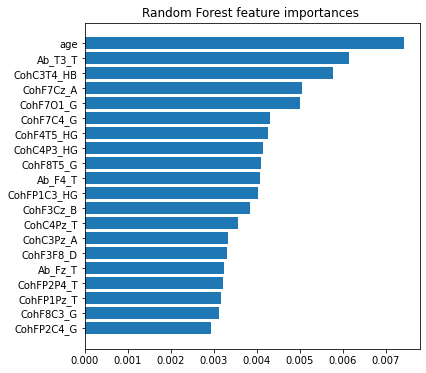

None


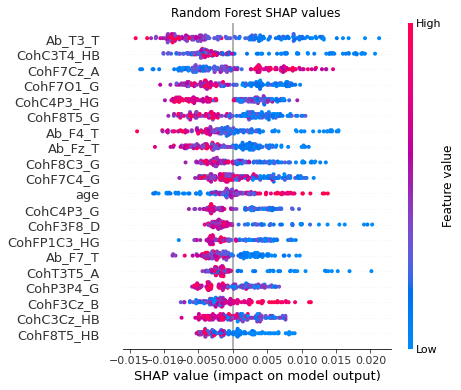

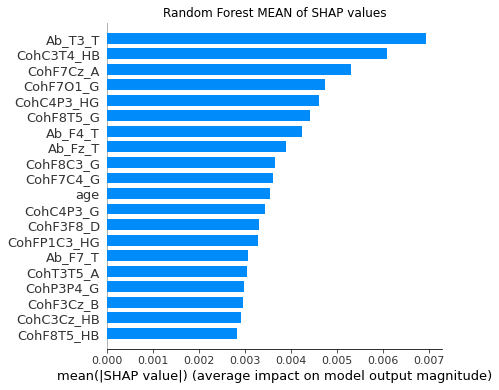

In [ ]:
# 확인 완료
data = pre_processing(EEG,cls=4)
EEG_whole3_imp = feature_whole_imp3(data,"EEG",cl4_best_model)
write_values(EEG_whole3_imp,"EEG_whole3_imp.xlsx")

LogisticRegression(C=0.1, l1_ratio=0.7, multi_class='multinomial',
                   penalty='elasticnet', random_state=2022, solver='saga')
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08797755115315306, 0.3267120255086784)
('NN50_time', 'RMSSD_time', 'SDNNi.SDNN.index.', 'age', 'log_HF_frequency', 'log_LF_HF_ratio_requency', 'log_LF_frequency', 'log_Power_VLF제외_frequency', 'log_Power_VLF포함_frequency', 'mean_HR_time', 'pNN50_time', 'sex', 'SDNN_time', 'sd_HR_time')


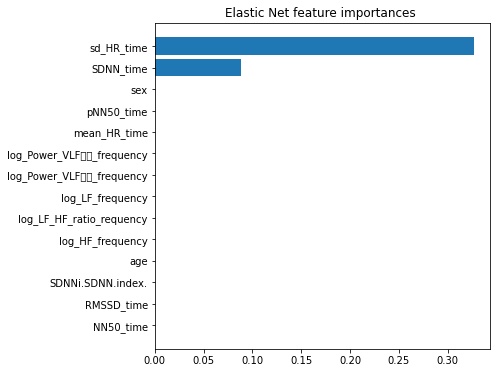

Using 156 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


None


  0%|          | 0/156 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# 확인 완료
data = pre_processing(HRV,cls=4)
HRV_whole3_imp = feature_whole_imp3(data,"HRV",cl4_best_model)

RandomForestClassifier(random_state=2022)
(0.010515629905109094, 0.02150936668457351, 0.043185958539759636, 0.04345917674252716, 0.04626532119417079, 0.050201082049468625, 0.05171441669998937, 0.06573192859334596, 0.07095557028252936, 0.08221447345313697, 0.09264229864902399, 0.09594861454394907, 0.10006244802346059, 0.11213719399439212, 0.11345652064456375)
('X5.marriage', 'sex', 'ECQ_공격성.통제', 'X3.education', 'BAS_Total', 'ECQ_정서통제', 'BIS', 'Barratt_total', 'BAI', 'CD.RISC', 'PWI.중개.', 'QOL_R총점', 'age', 'AQ_total', 'BDI')


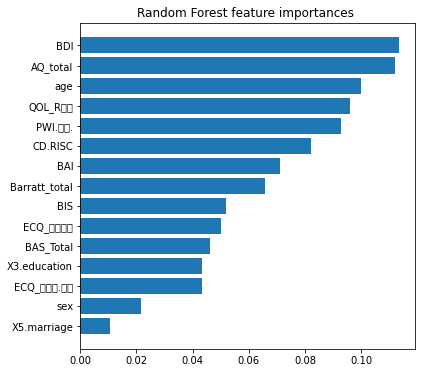

None


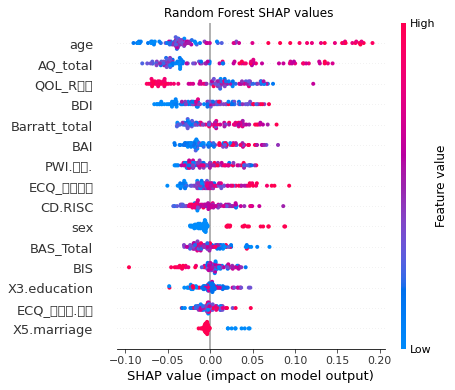

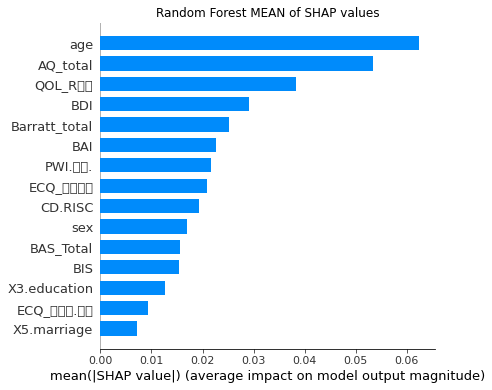

In [ ]:
# 확인 완료
data = pre_processing(clinical,cls=4)
Cli_whole3_imp = feature_whole_imp3(data,"clinical",cl4_best_model)

RandomForestClassifier(random_state=2022)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

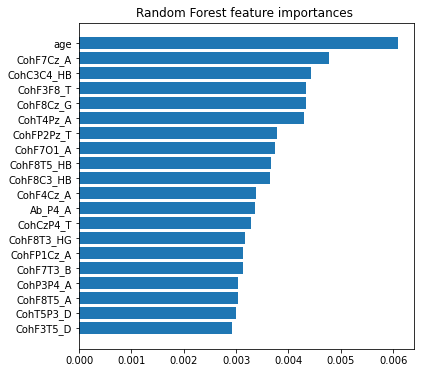

None


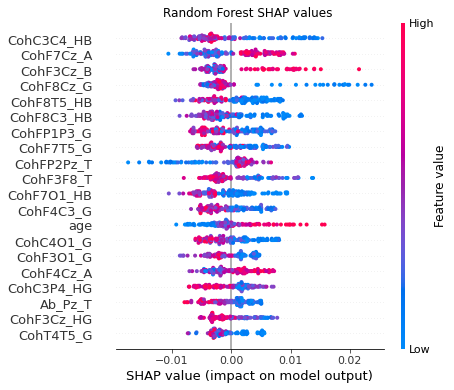

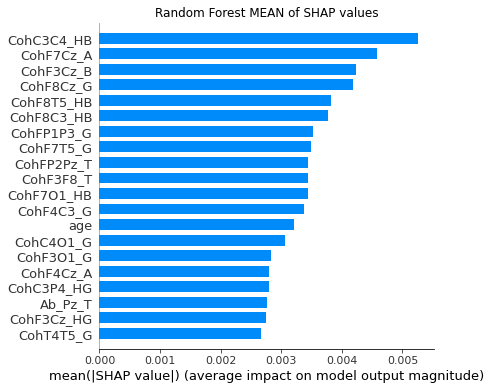

In [ ]:
# 확인 완료
data = pre_processing(EEGHRV,cls=4)
EEGHRV_whole3_imp = feature_whole_imp3(data,"EEGHRV",cl4_best_model)

In [ ]:
# 확인해 봐야함 
data = pre_processing(EEGCli,cls=4)
EEGCli_whole3_imp = feature_whole_imp3(data,"EEGCli",cl4_best_model)

KeyboardInterrupt: ignored

RandomForestClassifier(random_state=2022)


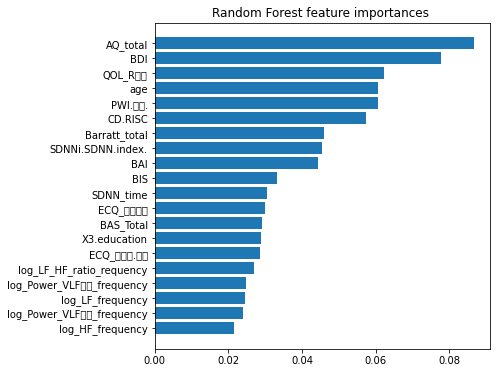

None


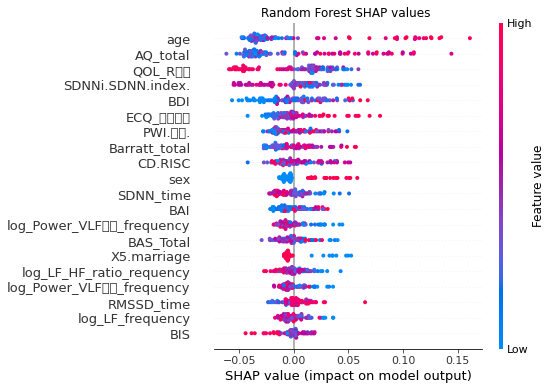

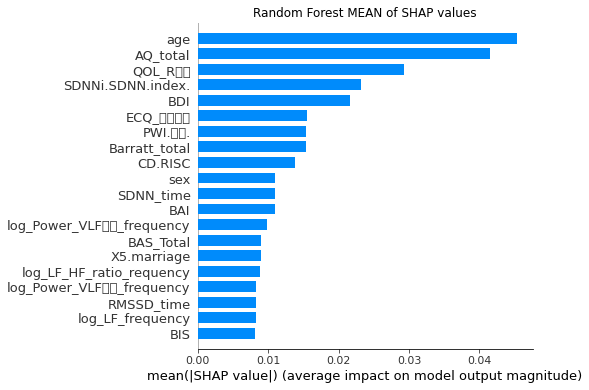

In [ ]:
# 확인 완료
data = pre_processing(HRVCli,cls=4)
HRVCli_whole3_imp = feature_whole_imp3(data,"HRVCli",cl4_best_model)

In [ ]:
# 확인해 봐야함 
data = pre_processing(EEGHRVCli,cls=4)
EEGHRVCli_whole3_imp = feature_whole_imp3(data,"EEGHRVCli",cl4_best_model)

KeyboardInterrupt: ignored

## 2Class - 전체변수


### EEG

In [ ]:
# 확인
data = pre_processing(EEG,cls=1)
EEG_cl1_whole2_imp = feature_whole_imp2(data,"EEG",cl1_whole_best)

KeyboardInterrupt: ignored

In [ ]:
data = pre_processing(EEG,cls=2)
EEG_cl2_whole2_imp = feature_whole_imp2(data,"EEG",cl2_whole_best)

In [ ]:
data = pre_processing(EEG,cls=3)
EEG_cl3_whole2_imp = feature_whole_imp2(data,"EEG",cl3_whole_best)

### HRV

LogisticRegression(C=0.001, l1_ratio=0, multi_class='multinomial',
                   penalty='elasticnet', random_state=2022, solver='saga')
(0.0013954668618307606, 0.0038330361895922422, 0.004864291752798256, 0.005002962062555987, 0.005515577688910299, 0.005526989286452952, 0.005693690245715312, 0.006560935943191863, 0.006898614601488816, 0.008241628822549326, 0.008813319671177247, 0.009025592063017267, 0.012140017019299147, 0.01820547744939139)
('sex', 'log_LF_HF_ratio_requency', 'SDNNi.SDNN.index.', 'pNN50_time', 'log_Power_VLF포함_frequency', 'age', 'log_HF_frequency', 'log_Power_VLF제외_frequency', 'log_LF_frequency', 'NN50_time', 'mean_HR_time', 'RMSSD_time', 'SDNN_time', 'sd_HR_time')


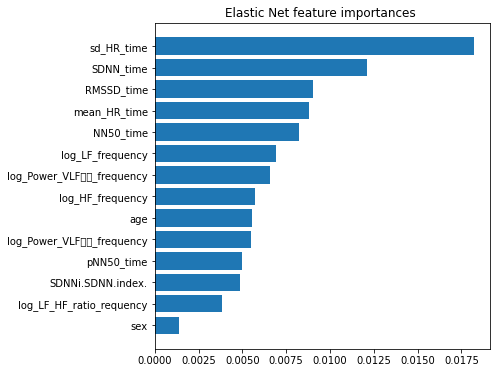

Using 156 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


None


  0%|          | 0/156 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# 확인 완료
data = pre_processing(HRV,cls=1)
HRV_cl1_whole2_imp = feature_whole_imp2(data,"HRV",cl1_whole_best)

In [ ]:
data = pre_processing(HRV,cls=2)
HRV_cl2_whole2_imp = feature_whole_imp2(data,"HRV",cl2_whole_best)

In [ ]:
data = pre_processing(HRV,cls=3)
HRV_cl3_whole2_imp = feature_whole_imp2(data,"HRV",cl3_whole_best)

### Clinical

In [ ]:
data = pre_processing(clinical,cls=1)
clinical_cl1_whole2_imp = feature_whole_imp2(data,"clinical",cl1_whole_best)

KeyboardInterrupt: ignored

In [ ]:
data = pre_processing(clinical,cls=2)
clinical_cl2_whole2_imp = feature_whole_imp2(data,"clinical",cl2_whole_best)

In [ ]:
data = pre_processing(clinical,cls=3)
clinical_cl3_whole2_imp = feature_whole_imp2(data,"clinical",cl3_whole_best)

### EEGHRV

In [ ]:
data = pre_processing(EEGHRV,cls=1)
EEGHRV_cl1_whole2_imp = feature_whole_imp2(data,"EEGHRV",cl1_whole_best)

In [ ]:
data = pre_processing(EEGHRV,cls=2)
EEGHRV_cl2_whole2_imp = feature_whole_imp2(data,"EEGHRV",cl2_whole_best)

In [ ]:
data = pre_processing(EEGHRV,cls=3)
EEGHRV_cl3_whole2_imp = feature_whole_imp2(data,"EEGHRV",cl3_whole_best)

### EEGCli

In [ ]:
data = pre_processing(EEGCli,cls=1)
EEGCli_cl1_whole2_imp = feature_whole_imp2(data,"EEGCli",cl1_whole_best)

In [ ]:
data = pre_processing(EEGCli,cls=2)
EEGCli_cl2_whole2_imp = feature_whole_imp2(data,"EEGCli",cl2_whole_best)

In [ ]:
data = pre_processing(EEGCli,cls=3)
EEGCli_cl3_whole2_imp = feature_whole_imp2(data,"EEGCli",cl3_whole_best)

### HRVCli

In [ ]:
data = pre_processing(HRVCli,cls=1)
HRVCli_cl1_whole2_imp = feature_whole_imp2(data,"HRVCli",cl1_whole_best)

In [ ]:
data = pre_processing(HRVCli,cls=2)
HRVCli_cl2_whole2_imp = feature_whole_imp2(data,"HRVCli",cl2_whole_best)

In [ ]:
data = pre_processing(HRVCli,cls=3)
HRVCli_cl3_whole2_imp = feature_whole_imp2(data,"HRVCli",cl3_whole_best)

### EEHGRVCli

In [ ]:
data = pre_processing(EEGHRVCli,cls=1)
EEGHRVCli_cl1_whole2_imp = feature_whole_imp2(data,"EEGHRVCli",cl1_whole_best)

In [ ]:
data = pre_processing(EEGHRVCli,cls=2)
EEGHRVCli_cl2_whole2_imp = feature_whole_imp2(data,"EEGHRVCli",cl2_whole_best)

In [ ]:
data = pre_processing(EEGHRVCli,cls=3)
EEGHRVCli_cl3_whole2_imp = feature_whole_imp2(data,"EEGHRVCli",cl3_whole_best)

## 2Class- 변수 선택

### EEG

LogisticRegression(C=0.001, l1_ratio=0, multi_class='multinomial',
                   penalty='elasticnet', random_state=2022, solver='saga')
(0.0005327034192978904, 0.0023402418363625806, 0.004721336240915365, 0.004948638661081452, 0.006052445117900638, 0.006265135854485614, 0.006429996912926855, 0.006835892632083604, 0.006998896668156647, 0.007720673026769349, 0.007785782386259338, 0.010042317394241189, 0.010099164702461368, 0.014225372807615483, 0.014567339537620157, 0.01484340587503025, 0.015996396925807836, 0.016929668880780336)
('CohF8C4_A', 'CohT3T4_B', 'CohC3Pz_HB', 'CohF3Cz_B', 'Ab_FP2_HB', 'CohPzO2_D', 'CohF4C4_B', 'CohT4O2_B', 'CohT3O2_A', 'CohP4O2_B', 'CohP4O2_D', 'CohFzCz_A', 'CohF4T4_HG', 'CohC3C4_HB', 'CohFP1T5_G', 'CohC3C4_G', 'CohC4O1_G', 'CohC3C4_HG')


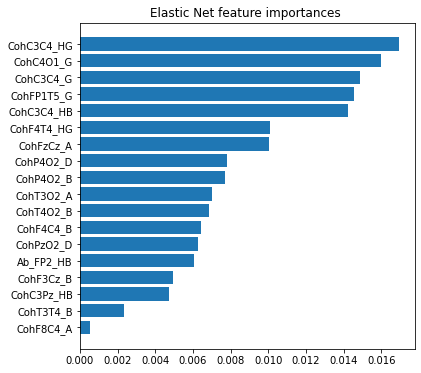

Using 156 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


None


  0%|          | 0/156 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
data = pre_processing(EEG,cls=1)
EEG_cl1_imp = feature_select_imp2(data,"EEG",cl1_best,cl1_features)

LogisticRegression(C=0.001, l1_ratio=0, multi_class='multinomial',
                   penalty='elasticnet', random_state=2022, solver='saga')
(0.0014003473694464768, 0.006179059770701428, 0.009464706081518965, 0.011539053933612087, 0.012559396111756315, 0.0152120521621717, 0.02079246279951751)
('sex', 'CohF8T4_D', 'CohFP1T6_T', 'Ab_P3_A', 'Ab_T6_B', 'CohT3P3_D', 'CohF8C3_HG')


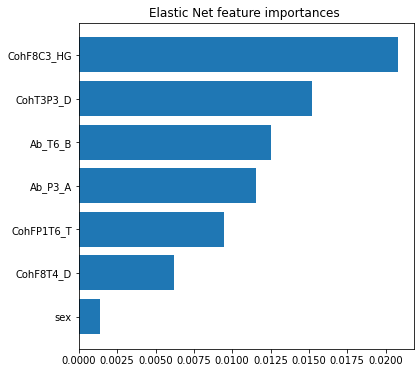

Using 156 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


None


  0%|          | 0/156 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
data = pre_processing(EEG,cls=2)
EEG_cl2_imp = feature_select_imp2(data,"EEG",cl2_best,cl2_features)

RandomForestClassifier(random_state=2022)
(0.49188907357587125, 0.5081109264241288)
('CohF8C3_HG', 'CohF8T5_HG')


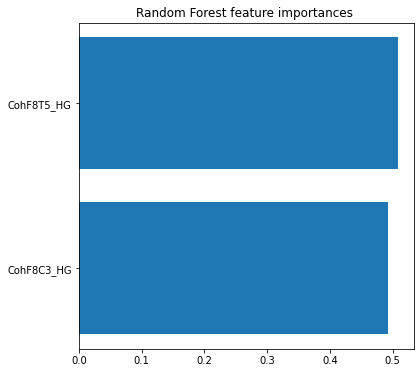

None


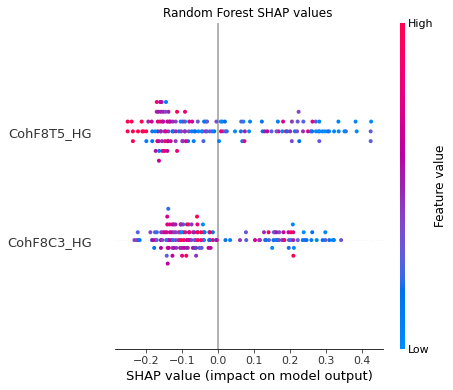

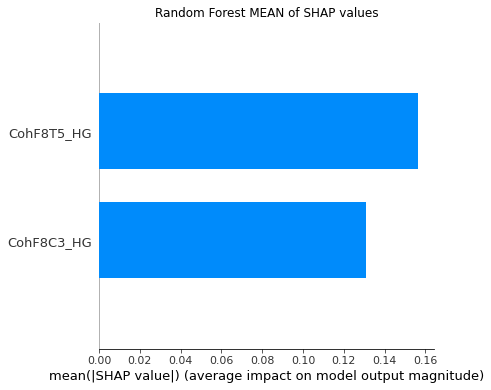

In [ ]:
data = pre_processing(EEG,cls=3)
EEG_cl3_imp = feature_select_imp2(data,"EEG",cl3_best,cl3_features)

### HRV

In [ ]:
data = pre_processing(HRV,cls=1)
HRV_cl1_imp = feature_select_imp2(data,"HRV",cl1_best,cl1_features)

In [ ]:
data = pre_processing(HRV,cls=2)
HRV_cl2_imp = feature_select_imp2(data,"HRV",cl2_best,cl2_features)

In [ ]:
data = pre_processing(HRV,cls=3)
HRV_cl3_imp = feature_select_imp2(data,"HRV",cl3_best,cl3_features)

### Clinical

In [ ]:
data = pre_processing(clinical,cls=1)
cli_cl1_imp = feature_select_imp2(data,"clinical",cl1_best,cl1_features)

KeyboardInterrupt: ignored

In [ ]:
data = pre_processing(clinical,cls=2)
cli_cl2_imp = feature_select_imp2(data,"clinical",cl2_best,cl2_features)

In [ ]:
data = pre_processing(clinical,cls=3)
cli_cl3_imp = feature_select_imp2(data,"clinical",cl3_best,cl3_features)

### EEGHRV

In [ ]:
data = pre_processing(EEGHRV,cls=1)
EEGHRV_cl1_imp = feature_select_imp2(data,"EEGHRV",cl1_best,cl1_features)

In [ ]:
data = pre_processing(EEGHRV,cls=2)
EEGHRV_cl2_imp = feature_select_imp2(data,"EEGHRV",cl2_best,cl2_features)

In [ ]:
data = pre_processing(EEGHRV,cls=3)
EEGHRV_cl3_imp = feature_select_imp2(data,"EEGHRV",cl3_best,cl3_features)

### EEGCli

In [ ]:
data = pre_processing(EEGCli,cls=1)
EEGCli_cl1_imp = feature_select_imp2(data,"EEGCli",cl1_best,cl1_features)

In [ ]:
data = pre_processing(EEGCli,cls=2)
EEGCli_cl2_imp = feature_select_imp2(data,"EEGCli",cl2_best,cl2_features)

In [ ]:
data = pre_processing(EEGCli,cls=3)
EEGCli_cl3_imp = feature_select_imp2(data,"EEGCli",cl3_best,cl3_features)

### HRVCli

In [ ]:
data = pre_processing(HRVCli,cls=1)
HRVCli_cl1_imp = feature_select_imp2(data,"HRVCli",cl1_best,cl1_features)

In [ ]:
data = pre_processing(HRVCli,cls=2)
HRVCli_cl2_imp = feature_select_imp2(data,"HRVCli",cl2_best,cl2_features)

In [ ]:
data = pre_processing(HRVCli,cls=3)
HRVCli_cl3_imp = feature_select_imp2(data,"HRVCli",cl3_best,cl3_features)

### EEGHRVCli

In [ ]:
data = pre_processing(EEGHRVCli,cls=1)
EEGHRVCli_cl1_imp = feature_select_imp2(data,"EEGHRVCli",cl1_best,cl1_features)

In [ ]:
data = pre_processing(EEGHRVCli,cls=2)
EEGHRVCli_cl2_imp = feature_select_imp2(data,"EEGHRVCli",cl2_best,cl2_features)

In [ ]:
data = pre_processing(EEGHRVCli,cls=3)
EEGHRVCli_cl3_imp = feature_select_imp2(data,"EEGHRVCli",cl3_best,cl3_features)